# Content
Files prepared: 
* 1_stock_list.xlsx = 3800 stock names + exchange names
* 2_names_all.xlsx = 3208 stock names + Indicies
* 3_names_with_curr.xlsx = 2_... + Currencies manually inputed + Indicator of rare currencies
* 3067 CSV of stock prices scraped
* 2996 stocks converted
* AIR.L.csv = stock for referential date column

## 1) Installing Packages

In [1]:
# 1.) General
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure  
import numpy as np
import math
from pandas import DataFrame
from math import sqrt
from datetime import datetime
import csv
import time
from datetime import date


## 2) Loading data from Notebook 1 - Scraping + Currencies
* ! Currencies were inputed manually based on the countries
* There was also added two Indicators of rare currencies to drop: 3208 -> 3129

In [13]:
path = "C:/Users/Desktop/Python/stocks/"

df = pd.read_excel(path + "3_names_with_curr.xlsx")
df.head()

,Names,Exchange,Indicies,Quotes,Country,Currency,Drop
2423,ORDINA,Euronext Amsterdam,ALL ORDINARIES (^AORD),^AORD,-,USD,NaN
1985,"STEINHOFF INTERNATIONAL HLDG.EO-,50",Deutsche Boerse,S&P 500 (^GSPC),^GSPC,-,USD,NaN
2138,EURONEXT,Euronext Lisbon,EURONEXT 100 (^N100),^N100,-,USD,NaN
2091,PEARL GOLD AG,Deutsche Boerse,Pearl Gold AG (02P.F),02P.F,F,EUR,NaN
707,HANATOUR SERVICE INC.,London,Hanatour Service Inc. (039130.KS),039130.KS,KS,KRW,Y


In [14]:
df.groupby('Currency')['Quotes'].nunique()

Currency
AUD       9
CAD      10
CHF       5
DKK       1
EUR    1386
GBP    1456
HKD       2
IDR       1
INR      10
JPY       2
KRW       3
MXN       1
NOK       1
RUB      20
SGD       1
THB       1
TWD      11
USD     287
ZAC       1
Name: Quotes, dtype: int64

## 3) Dropping

### 3.1) Drop of the rare currencies 3208 -> 3129

In [15]:
df = df[df.Drop != "Y"]
df = df[df.Drop != "M"]

df.reset_index(inplace = True, drop = True)
display(len(df))
df.groupby('Currency')['Quotes'].nunique()

3129

Currency
EUR    1386
GBP    1456
USD     287
Name: Quotes, dtype: int64

### 3.2) Dropping extreme values - structural breaks - "weirdly acting stocks"

* This is what I actualyl found out after the step 5.3)

In [ ]:
droppy = ["SERE.L", "GWMGF", "EUZ.L", "VAL.L", "ERIS.L", "ROL.L" ,"EUA.L" ,"CNS.L", "SCF.L", "UANC.L" , "KGF.L" , "PIRI.L", "LOOP.L", "CGO.L", "SPA.L" , "GRA.L" , "IVPG.L" , "SKIN.L", "BGEU.L",\
 "BOO.L", "SRT.L", "CPP.L" , "GUN.L" , "PHM.L" , "KIBO.L", "MTR.L", "HYVE.L", "URU.L", "BPM.L" ,"SENX.L", "ADAM.L", "BOOM.L", "BZPA.F", "ALDV.PA", "OPP.L", "SDXEF", "ADN1.DE", "NBB.L" , "MIRA.L" , \
 "VAF.LS" , "ALCES.PA", "SGRO.L" , "ZENT.BR" , "NSI.AS", "IEM.L", "DGN.L" , "CTY.L", "LWDB.L", "DGN.L", "BHGG.L", "MLEVE.PA", "VTA.AS"]
display(len(droppy))

df = df.drop(columns=droppy)

## 4) Conversion of GBP and EUR into USD 3129 -> 2996, 4120 -> 4372 rows
* Takes about 7 min

In [ ]:
# Currencies to be converted into USD
currencies = ["GBP", "EUR"] 

In [ ]:
def merge_currencies():
    
    # Adding referential column with dates: 1.1.2004 - 31.12.2019
    refer = pd.read_csv(path + "AIR.L.csv")
    refer = refer[["Date"]].copy()
    refer['Date'] = pd.to_datetime(refer['Date'])
    refer = refer[ refer.Date < pd.Timestamp(date(2020,1,1))].copy()
    refer = refer[ pd.Timestamp(date(2003,12, 31)) < refer.Date].copy()
    refer.reset_index(inplace = True, drop = True)

    for i in currencies:

        # Selects only stocks of the given currency 
        group = names[names.Currency == i]
        group = group.Quotes

        # Creates a history of exchange rates for the given currency -> USD
        curr = pd.read_csv(path + "USD" + i + "=X.csv")    
        curr = curr[["Date", "Close"]].copy()   ## !!!!!! Změna !!!
        curr['Date'] = pd.to_datetime(curr['Date'])
        curr = curr[ curr.Date < pd.Timestamp(date(2020,1,1))].copy()
        curr = curr[ pd.Timestamp(date(2003,12, 31)) < curr.Date].copy()
        curr.reset_index(inplace = True, drop = True)

        for j in group:
            try:
                # For each stock of our "currency group" select Close price in the given Date range
                s = pd.read_csv(path + j + ".csv")
                s = s[["Date", "Close"]].copy()       ## !!!!!! Změna !!!
                s['Date'] = pd.to_datetime(s['Date'])
                s = s[ s.Date < pd.Timestamp(date(2020,1,1))].copy()
                s = s[ pd.Timestamp(date(2003,12, 31)) < s.Date].copy()
                s.reset_index(inplace = True, drop = True)

                # Combines exchange rate and daily price and converts it
                mix = pd.merge(s, curr, on=['Date'], how = "left")           
                mix[j] = mix["Close_x"]/mix["Close_y"]   
                
                # New column is named after the stock
                mix = mix[["Date", j]]                                   

                # Adding newly converted prices to the overall df
                refer = pd.merge(refer, mix, on = ["Date"], how = "outer")  
                refer = refer.sort_values(by="Date")
                refer = reger.reset_index(inplace = True, drop = True)

            except:
                pass
            
    ####################################################################
    ### Adding the non-converted data of USD stocks in the simmilar way
    ####################################################################
            
    # Vytvoří skupinu všech Quotes daných měn
    group = names[names.Currency == "USD"]
    group = group.Quotes

    for j in group:
        try:
            s = pd.read_csv("C:/Users/jiri.zelenka/Desktop/Python/Diplomka - AKCIE/stocks/3208 resp 3068/" + j + ".csv")
            s = s[["Date", "Close"]].copy()      
            s['Date'] = pd.to_datetime(s['Date'])
            s = s[ s.Date < pd.Timestamp(date(2020,1,1))].copy()
            s = s[ pd.Timestamp(date(2003,12, 31)) < s.Date].copy()
            s.reset_index(inplace = True, drop = True)

            # Simply takes the column, no conversion
            mix = s.copy()
            mix[j] = mix["Close"]            
            mix = mix[["Date", j]]                                     

            refer = pd.merge(refer, mix, on = ["Date"], how = "outer")  
            refer = refer.sort_values(by="Date")
            refer = reger.reset_index(inplace = True, drop = True)

        except:
            pass

    return refer
 

In [17]:
## 7 mins !  
## Converts all the currencies into USD

df = merge_currencies()
df.head()


,Unnamed: 0,Date,3IN.L,46HA.L,7DIG.L,888.L,AA.L,AA4.L,AAA.L,AAAP.L,...,VWAGY,VZ,WHELF,WIMHY,WISKF,WPP,XPO,YTRA,ZDGGF,Return
0,0,2004-01-01,NaN,NaN,553.413310,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,1,2004-01-02,NaN,NaN,556.043838,NaN,NaN,NaN,NaN,NaN,...,NaN,31.701128,NaN,NaN,NaN,49.500000,5.24,NaN,NaN,0.03011
2,2,2004-01-05,NaN,NaN,560.234214,NaN,NaN,NaN,NaN,NaN,...,NaN,32.618435,NaN,NaN,NaN,51.270000,5.24,NaN,NaN,0.01296
3,3,2004-01-06,NaN,NaN,564.601319,NaN,NaN,NaN,NaN,NaN,...,NaN,33.158031,NaN,NaN,NaN,51.750000,5.40,NaN,NaN,0.00624
4,4,2004-01-07,NaN,NaN,563.513415,NaN,NaN,NaN,NaN,NaN,...,NaN,32.879238,NaN,NaN,NaN,52.380001,6.00,NaN,NaN,-0.00264


### 4.1) Little inspection

In [18]:
df.count().mean()  # Average number of the days traded
df.count(axis = 1).mean() # Average number of stocks traded per day
df.mean(axis = 1)  # Average daily price in USD

0       1060.409276
1        741.450860
2        744.030962
3        738.781354
4        732.253709
5        744.342893
6        755.150838
7        741.281506
8        737.030940
9        735.365803
10       745.538509
11       748.744776
12       750.948182
13       743.519715
14       753.330993
15       776.515924
16       774.971999
17       774.036651
18       777.831578
19       759.594277
20       768.130812
21       767.134153
22       752.790111
23       759.513528
24       765.223010
25       760.695394
26       777.375205
27       779.276510
28       802.813234
29       809.528377
           ...     
4067     276.487073
4068     275.251068
4069     274.541586
4070     275.660140
4071     276.473193
4072     278.578170
4073     279.027454
4074     280.346313
4075     279.025640
4076     277.489270
4077     275.831342
4078     277.786643
4079     280.002983
4080     282.401622
4081     281.971101
4082     280.777525
4083     279.711367
4084     281.854417
4085     292.868918


## 5) Equally weighted portfolio

### 5.1) Cutting extreme values - rare occurencies

In [ ]:
def correction(df):
    
    corrected = 0
    
    # Edit all coulmns but Date column
    for i in df.columns[df.columns !='Date']:
        
        x = df[i].dropna()
        
        for j in range(len(x)-2):
            if (abs(x.iloc[j+1] - x.iloc[j]) > 1.5*abs(x.iloc[j]) ) & (abs(x.iloc[j+1] - x.iloc[j+2]) > 1.5*abs(x.iloc[j+2])) | \
            (abs(x.iloc[j+1] - x.iloc[j]) > 1.5*abs(x.iloc[j+1]) ) & (abs(x.iloc[j+1] - x.iloc[j+2]) > 1.5*abs(x.dropna().iloc[j+1])):
                #  If there are  extreme changes in the consecutive values, meaning more than 150 % daily growth/decline
                
                ###  compared to the original [j] and final [j+2] value, if difference is bigger than initial value  
                ### compared to the middle value, if difference is bigger than this value

                ### !! iloc[] works with relative order, loc[] loc works with the actual index (if is is not reset, it differs from iloc)
                
                df[i].loc[df[df[i] == x.iloc[j+1]].index.tolist()[0]] = (x.iloc[j] + x.iloc[j+2])/2
                #      [ This is index where X has problematic value]  ->  # Replace with mean of surrounding values from 
                # df is original dataframe, loc[] finds the row where value df[i] equals the suspiscious df[i].dropna().iloc[j+i]
                
                corrected +=1

    print(corrected)  # 7.363 values total
    return df

In [ ]:
df = correction(df)

### 5.2) Filling NaN values
* !! Worked better if the 3.000 columns were split into 6x dfs of 500 columns

In [ ]:

def fillNaNs(df):
    
    # for all but the first column:
    for i in df.columns:
        for j in range(1,len(df)-1):  
            
            # If there is a NUMBER - SPACE - NUMBER, fill it with their mean
            if (np.isnan(df[i].iloc[j])) & (np.isfinite(df[i].iloc[j-1])) & (np.isfinite(df[i].iloc[j+1])):
                df[i].iloc[j] = (df[i].iloc[j-1]+df[i].iloc[j+1])/2
                
            # if there is NUMBER - SPACE - SPACE
            elif (np.isnan(df[i].iloc[j])) & (np.isfinite(df[i].iloc[j-1])) & (np.isnan(df[i].iloc[j+1])):
                
                # try to find the end of spaces
                try:
                    a = df[i].iloc[j:].first_valid_index()
                    step = (df[i].iloc[a] - df[i].iloc[j-1])/(a-j-1)
                    # (a-j-1) = number of steps I need to divide my filled value

                    # In the first SPACE ending before the las NUMBER
                    for k in range(j, a):        
                        df[i].iloc[k] = df[i].iloc[k-1] + step

                except:
                    pass

    return df

In [ ]:
df = fillNaNs(df)

### 5.3) Calculate Returns of portfolio

In [ ]:
def returns(df):
    
    # Separate Date column
    df_date = df.Date
    df = df[df.columns.difference(['Date'])]
    
    # Create list of 0 returns
    df["Return"] = [0] * len(df)
    
    # STart with the second line
    for i in range(1,len(df)):
        
                            #    take value[For columns but Return itself  ]       / Divide by the previous value                    ) take their mean
        df["Return"].iloc[i] = round(((df[df.columns.difference(['Return'])].iloc[i]/df[df.columns.difference(['Return'])].iloc[i-1]).mean()-1), 5)
    
    # concat Date and Prices and Returns altogether
    df = pd.concat([df_date, df], axis=1, sort=False)

    return df

In [24]:
df = returns(df)
df.Return.head()

0    0.00000
1    0.03011
2    0.01296
3    0.00624
4   -0.00264
Name: Return, dtype: float64

## 6) Plotting Returns

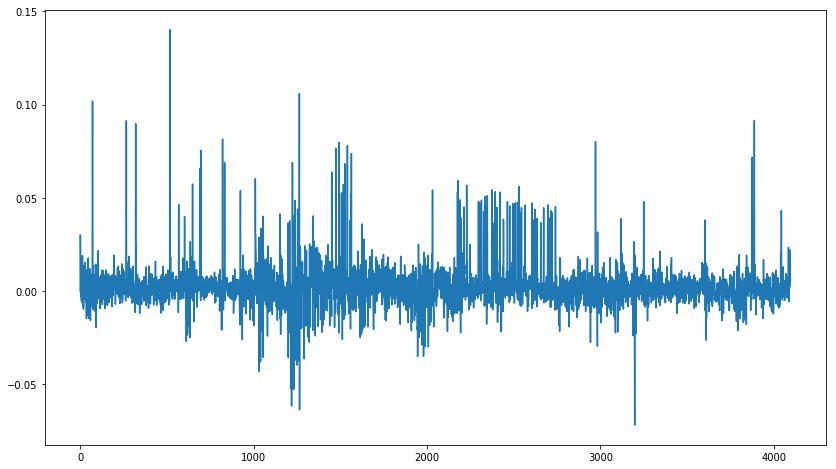

In [25]:
fig = plt.gcf()
fig.set_size_inches(14,8)

plt.plot(df["Return"])

## 7) The end of the Part 2